# Proyecto Final Área Imágenes: 
EL5206 Laboratorio de Inteligencia Computacional y Robótica
- Profesor: Claudio Pérez F
- Profesor Auxiliar: Juan Pablo Pérez
- Estudiantes: Pablo Yáñez M, Magdalena De La Fuente

## Content Based Image Retrieval (CBIR)
El Content Based Image Retrieval consiste en una técnica de búsqueda de imágenes. El usuario provee de una imagen y el sistema devuelve imágenes similares. Esto se logra extrayendo, a través de algoritmos, características de las imágenes.

* **Objetivo del Proyecto**

    El objetivo de este proyecto final es desarrollar e implementar un algoritmo de búsqueda de imágenes similares basado en su contenido (Content Based Image Retrieval, CBIR) utilizando distintos métodos de extracción de características. 

* **Sobre las imágenes**

    Se utilizan los datasets INRIA Holidays dataset y GPR1200. El primero consiste en imágenes de consulta para 500 clases, mientras que el segundo consta de 1200 clases con 10 ejemplos por clase. 

* **Sobre el trabajo realizado**
  
    En este informe se aborda la implementación de distintos métodos para atacat la problemática CBIR. 

    El primer método consiste en la construcción de un método de obtención de vectores característicos "handcrafted", en donde se utiliza un modelo de Bag of Visual Words. Este obtiene descriptores provisos por el algoritmo SIFT, luego clusteriza estos descriptores y finalmente encuentra las palabras visuales. Esta información es finalmente proyectada en un histograma, y estos histogramas se almacenan en un archivos .csv. Por cada imagen del dataset hay un histograma. 

    El segundo método implementado utiliza redes neuronales convolucionales para generar vectores característicos. 

    El tercer método implementado correponde a la fusión de los vectores característicos del método handcrafter y el método por CNN. Estos vectores se concatenan para formar un solo vector característico por imagen, y luego son enviados a un proceso de LDA para reducir la dimensionalidad, obteniéndose finalmente, un vector unimidensional más corto que CNN pero más largo que a través del método hand crafted.

* **Sobre el código implementado**

    Todas las funciones implementadas han sido empaquetadas para hacer uso de estas de manera fácil en múltiples archivos o notebooks. Los modulos se pueden encontrar en la carpeta src del respositorio. 




#### Medidas de similitud y vectores característicos

* **Sobre el cálculo de los vectores característicos y su almacenamiento**
  
    Los vectores característicos obtenidos en este proyecto han sido almacenados en un archivos csv, para obtenerse facilmente.

* **Medidas de similitud**
    Las medidas de similitud implementadas son:
	
    Euclidiana: $\sqrt{\sum_{i=1}^n\left(x_i-p_i\right)^2}$
   
    
    Coseno: $\frac{\sum_{i=1}^n A_i B_i}{\sqrt{\sum_{i=1}^n A_i^2 \cdot \sum_{i=1}^n B_i^2}}$

   	
	Manhattan: $|x_1 - x_2| + |y_1 - y_2|$


In [1]:
import pandas as pd 
from src.SIFT.SIFT_gen_and_utils import SIFTFeatures  
import matplotlib.pyplot as plt 
from src.Metrics.metrics_utils import get_hist_from_str, plot_10, plot_histogram, query_image, precision_recall, consult_all, query_image_normal

In [2]:
df = pd.read_csv('/root/labint/LabInt/LabInt/final_histograms.csv')
SIFT = SIFTFeatures("", "", run=False)

In [3]:
df["class"] = df["image_name"].apply(lambda x: SIFT.get_class(x))
df["features_histogram"] = df["features_histogram"].apply(lambda x: get_hist_from_str(x, separator=' '))
df["features_fusion"] = df["features_fusion"].apply(lambda x: get_hist_from_str(x, separator=','))
df["features_CNN"] = df["features_CNN"].apply(lambda x: get_hist_from_str(x, separator=','))
#df.head()

In [4]:
#PARAMETROS GLOBALES
IMAGE_EXAMPLE = df["image_name"][0]
MEASURE = 'cosine'
PATH_TO_IMAGES = '/root/labint/LabInt/LabInt/data/GPR1200/images'

### Método Handcrafted

El método handcrafted consiste de cuatro pasos:

##### 1. Generación de decriptores por SIFT

> El algoritmo *Scale Invariant Feature Transform (SIFT)* es un algoritmo de visión computacional de extraccion de características para imágenes. Como dice su nombre, es invariante a la escala y rotación de una imagen. Se utiliza en una variedad de aplicaciones, entre ellas el reconocimiento de objetos, mapeo robótico, navegación, modelamiento 3d, etc. 

Este algoritmo retorna una lista de valores descriptores que corresponden a posiciones en la imagen que cumplen alguna particularidad.  En esta ocasión se fijó el numero de descriptores a generar por imagen en 10000. Se utiliza la funcion `cv2.SIFT_create()` y luego `sift.detectAndCompute()` para calcularle los descriptores a cada imagen. Como mencionado antes la ventaja de utilizar SIFT es la invarianza de los descriptores a la rotación y escalamiento, sin embargo, una desventaja es que no es sensible al color, ya que las imágenes son convertidas a escala de grises antes de computar los descriptores. Esto a la vez lo vuelve sensible al constraste de la imagen. 

##### 2. Obtención de clusters por Kmeans 
Debido al alto volumen de datos generado por SIFT, solo se utiliza un subconjunto de imagenes para construir los clusteres de palabras. Por supuesto, el subconjunto a sido balanceado y estratificado para evitar problemas asociados al desbalance de clases. Se utilizó un subsampling de 0.35, es decir, 35% de la data total. Numéricamente esto corresponde a 4721 imágenes de un total de 13491. 

> En Kmeans se debe elegir un número de clusters a encontrar por el algoritmo. Uno de los métodos más comunes para seleccionar el número de clusters es el método del codo. Este consiste en encontrar el punto de inflexión en una curva de pérdida SSE (sum of squared errors).

En esta ocasión el número de clusters es 120. 

##### 3. Cuantización Obtencion de palabras visuales
Para obtener las palabras visuales se obtienen los 120 centroides generados en la sección 2. Luego, para la data no perteneciente al subconjunto mencionado antes, se asocia cada datapoint a el cluster correspondiente. Esta metodología permite reducir significativamente los tiempos de computo para un dataset de gran tamaño.   

##### 4. Construcción de histogramas
El último paso en este método es la construcción de histogramas. Se utiliza la funcion `np.histogram()` de numpy para construir un histograma donde el número de bins es el número de clusters obtenido por el método del codo anteriormente.



#### Plot de un histograma handcrafted

A continuación se muestra el histograma generado para una imagen del dataset utilizando el método handcrafted. Tiene 120 bins, correspondiente al número de clusters señalado por el método del codo.

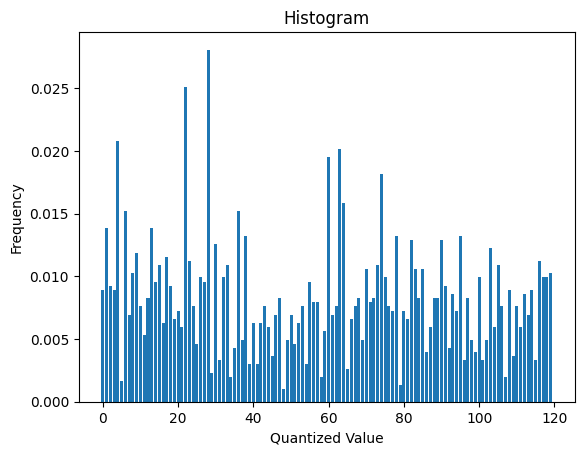

In [9]:
plot_histogram(df, 0, 120,feature_type="histogram")

Para consultar una imagen, se utiliza la función query_image. Esta función recibe una base de datos (dataframe), la medida de similitud y el tipo de feature a utilizar. Internamente, calcula la similitud entre la imagen de consulta y el resto de las imágenes en la base de datos. Finalmente ordena el dataset según menor similitud.

#### Hacer una querie sobre la base de datos utilizando el método de histograma.

In [10]:
df_query_hand = query_image_normal(df, IMAGE_EXAMPLE, measure=MEASURE, feature_type = "histogram")
df_query_hand.head()

image_name  \
0                    0_430b273cb7915d83.jpg   
1  283_48d56dde4ff947636e6d2e88fe0944d7.jpg   
2                        445_sketch_32.JPEG   
3                   48_5242ac0bf47e7b3a.jpg   
4  302_592813d0442d8954ad830cf27415c95c.jpg   

                                  features_histogram  \
0  [0.00891516, 0.01386802, 0.00924535, 0.0089151...   
1  [0.00996485, 0.00996485, 0.00996485, 0.0101602...   
2  [0.00770769, 0.01268805, 0.00889349, 0.0088934...   
3  [0.01037963, 0.00834883, 0.00947705, 0.0094770...   
4  [0.00871297, 0.00789099, 0.01512441, 0.0096993...   

                                        features_CNN      class  \
0  [0.029053612, 0.005296911, 0.04431615, 8.36852...    0_type1   
1  [0.020358194, 0.0023548284, 0.013760073, 2.647...  283_type1   
2  [0.021581432, 0.008826437, 0.047995437, -0.002...  445_type1   
3  [0.008390966, -0.0010573659, 0.00018312386, -0...   48_type1   
4  [0.014047221, 0.0009004294, 0.016000567, -0.00...  302_type1   

                                     features_fusion  similarity  
0  [-2.613821, 2.5879636, -0.439339, 2.8203344, -...    0.000000  
1  [-1.1635916, 1.606958, 0.5549883, -1.4256543, ...    0.054444  
2  [-3.5754519, -0.30903798, -0.76512164, 0.64123...    0.060710  
3  [-0.3229542, 2.5111763, -0.59074354, -0.147908...    0.061330  
4  [0.88486856, 1.4879302, -2.5667968, -1.0931183...    0.061934

Una vez ordenado el dataset según similitud, se pueden graficar las imágenes de mayor similitud.

#### Plot de la consulta y sus matches más cercanos.

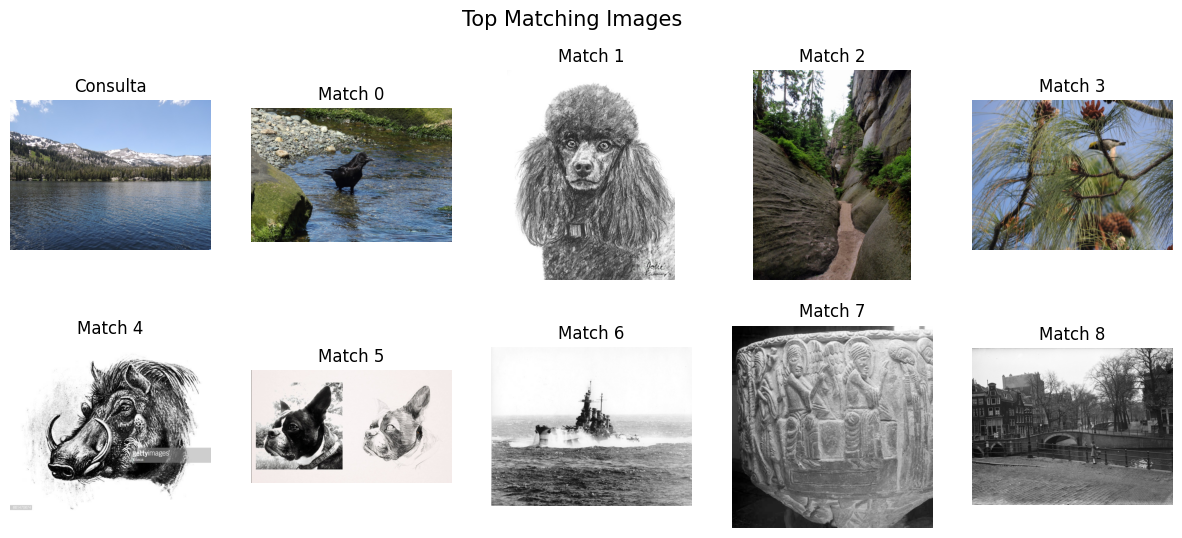

In [11]:
plot_10(df_query_hand,PATH_TO_IMAGES)

### Método por CNN

Las redes neuronales convolucionales corresponden a un tipo de aprendizaje profundo. Son consideradas altamente efectivas en el procesamiento de imágenes y videos. Este tipo de redes llevan a cabo la generalización y clasificacion gracias a la extracción de caracterísicas a través de convoluciones matemáticas. 

En general, construir una red CNN efectiva no es una tarea fácil. Es por esto que se recurrió a la internet para buscar algun modelo pre-entrenado que pudiera ser utilizado en la tarea de busqueda de contenido por imágenes propuesta en el enunciado. 

Tomando esto en consideración, para esta sección del proyecto se trabaja con la red entrenada disponible en [este repositorio](https://github.com/USCDataScience/Image-Similarity-Deep-Ranking) y el paper asociado se puede encontrar [aquí](https://github.com/USCDataScience/Image-Similarity-Deep-Ranking/blob/master/deep_ranking.pdf). *Image-Similarity-Deep-Ranking* es una red entrenada para encontrar similitudes entre imágenes a través de Deep Learning. Como CBIR es una problemática asociada a encontrar imágenes similares, y no el clasificar imágenes, se puede utilizar esta arquitectura disponible para generar histogramas. El input de la red son las imágenes de INRIA Holiday y GPR1200, la salida corresponde a un vector característico de largo 4096.


In [5]:
print(type(df['features_CNN'][400]))

<class 'numpy.ndarray'>


In [6]:
df['features_CNN'][400]

array([ 1.3623845e-02,  7.8288000e-03,  3.9950915e-02, ...,
        4.1242022e-02, -9.2611845e-05, -1.5748193e-03], dtype=float32)

#### Plot de un vector característico obtenido luego del entrenamiento

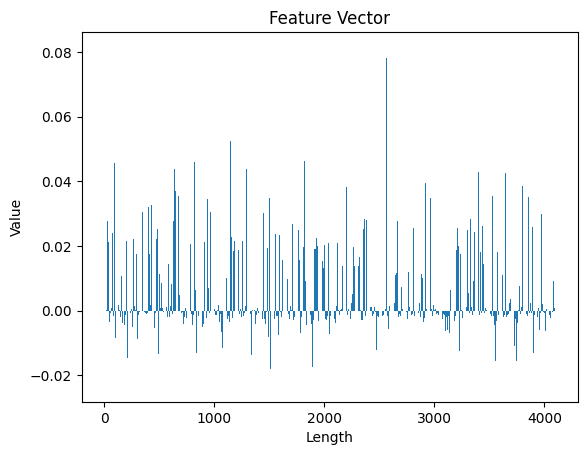

In [7]:
plot_histogram(df,0,n_bins=4096, feature_type='CNN')

#### Hacer una querie sobre la base de datos utilizando el método CNN.

In [ ]:
df_query_CNN = query_image_normal(df,IMAGE_EXAMPLE, measure=MEASURE, feature_type = "CNN")

#### Plot de la consulta y sus matches más cercanos

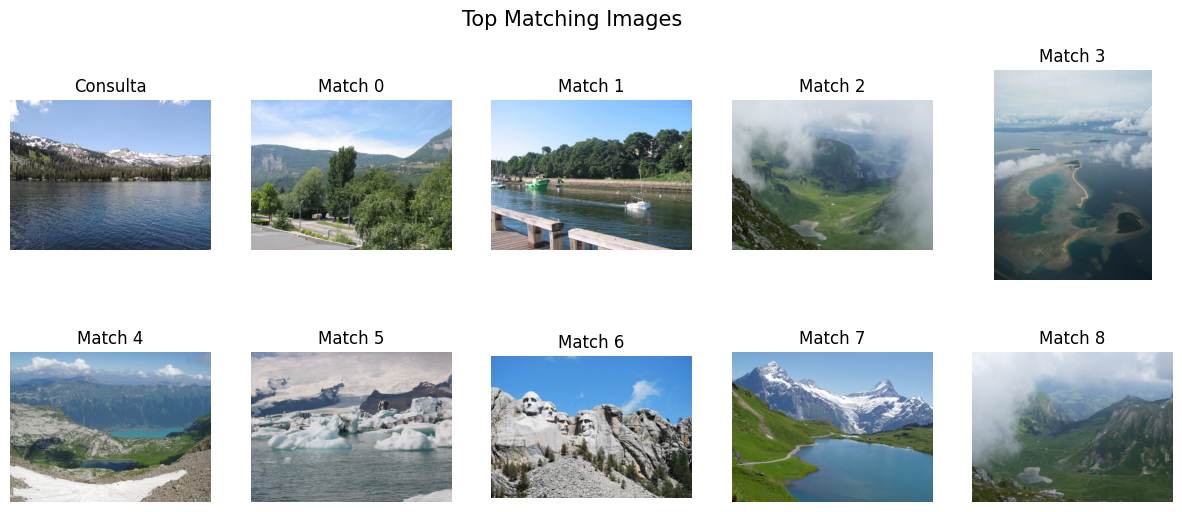

In [ ]:
plot_10(df_query_CNN,PATH_TO_IMAGES)

Al igual que para el método handcrafted, se utiliza la funcion query_image para consultar por una imagen a elección.

### Metodo fusión

Distintos métodos de obtención de características pueden recoger distintos patrones en la data. Es por esto que al combinar métodos, podría ser posible obtener mejores resultados. En este proyecto se decidió fusionar los dos métodos construidos (BoVW y CNN) a través de la concatenación de los vectores generados en cada método. Es decir, para cada vector característico del dataset, se combino a través de concatenación el vector BoVW de largo 120, con el vector CNN de largo 4096, obteniéndose un vector combinado de largo 4216. 

Además, como el objetivo es disminuir los tiempos de consulta, se transforma la data por medio de LDA (Linear Discriminant Analysis), reduciéndose la dimensionalidad del vector concatenado a un largo de 1698. Se utilizaron los parámetros de LDA por defecto, ya que entregó buenos resultados. Además, alterar por ejemplo, el solver del LDA, podrían aumentar los tiempos de cómputo sin entregar mejores resultados.

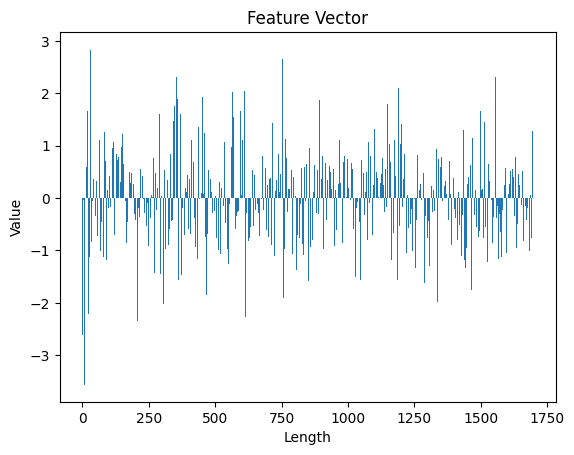

In [5]:
plot_histogram(df,0,n_bins=1698, feature_type='fusion')

#### Hacer una querie sobre la base de datos utilizando el método fusionado.

In [ ]:
df_fusion_query = query_image_normal(df, IMAGE_EXAMPLE, measure=MEASURE, feature_type = "fusion")

#### Plot de la consulta y sus matches más cercanos

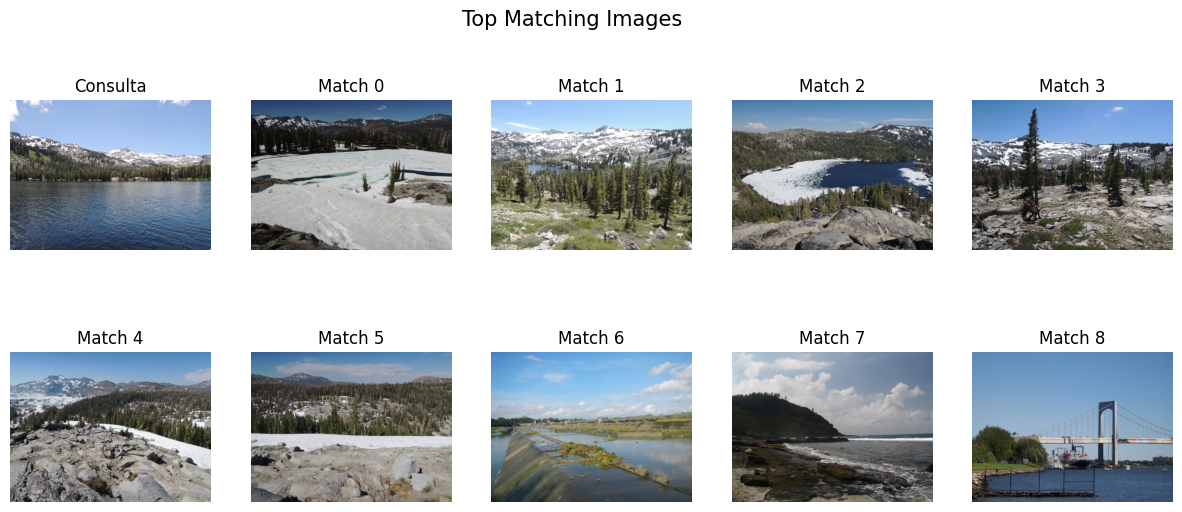

In [ ]:
plot_10(df_fusion_query,PATH_TO_IMAGES)

## Análisis, discusión y resultados.


Con la función `consult_all()` se puede hacer un query a cada método de manera integrada y presentar los resultados. Además, se printea cuanto se ha demorado la consulta en cada método. 

### Box Plot de Rank y Rank Normalizado

Para evaluar los métodos implementados, se utiliza la medida de `rank`, definida segun:

$$R a n k=\frac{1}{N_{r e l}} \sum_{i=1}^{N_{r e l}} R_i$$

Esta medida también puede ser normalizada segun: 

$$
\widetilde{\operatorname{Rank}}=\frac{1}{N \times N_{r e l}}\left(\sum_{i=1}^{N_{r e l}} R_i-\frac{N_{r e l}\left(N_{r e l}+1\right)}{2}\right)
$$

Para reducir los tiempos de cómputo, se decidió pre calcular las matrices de similitud para cada método y guardarlas en un archivo pickle.
De esta forma la complejidad de la consulta se reduce a $O(1)$, ya que solo se debe cargar la matriz de similitud y buscar el ranking de la imagen de consulta.

In [ ]:
import joblib
matrix = joblib.load("/mnt/c/Users/pyanez/Desktop/pablo/universidad/LabInt/dataset/similarity_matrix_histogram.pkl")
matrix

array([[0.        , 0.20792961, 0.17298329, ..., 0.168993  , 0.06602877,
        0.13881695],
       [0.20792961, 0.        , 0.04290539, ..., 0.25442272, 0.16046566,
        0.15299368],
       [0.17298329, 0.04290539, 0.        , ..., 0.2133764 , 0.12506098,
        0.11182171],
       ...,
       [0.168993  , 0.25442272, 0.2133764 , ..., 0.        , 0.09248215,
        0.06266314],
       [0.06602877, 0.16046566, 0.12506098, ..., 0.09248215, 0.        ,
        0.05643654],
       [0.13881695, 0.15299368, 0.11182171, ..., 0.06266314, 0.05643654,
        0.        ]])

In [ ]:
matrix_cnn = joblib.load("/mnt/c/Users/pyanez/Desktop/pablo/universidad/LabInt/dataset/similarity_matrix_CNN.pkl")
matrix_cnn

array([[0.        , 0.16609001, 0.04163867, ..., 0.29356354, 0.29352826,
        0.37110251],
       [0.16609001, 0.        , 0.05826247, ..., 0.07082683, 0.08669192,
        0.10930037],
       [0.04163867, 0.05826247, 0.        , ..., 0.13761348, 0.14190733,
        0.19390017],
       ...,
       [0.29356354, 0.07082683, 0.13761348, ..., 0.        , 0.01676929,
        0.01750785],
       [0.29352826, 0.08669192, 0.14190733, ..., 0.01676929, 0.        ,
        0.01736057],
       [0.37110251, 0.10930037, 0.19390017, ..., 0.01750785, 0.01736057,
        0.        ]])

In [ ]:
matrix_fusion = joblib.load("/mnt/c/Users/pyanez/Desktop/pablo/universidad/LabInt/dataset/similarity_matrix_fusion.pkl")
matrix_fusion

array([[0.        , 0.87089129, 0.87065384, ..., 0.99826592, 0.96360257,
        0.9554809 ],
       [0.87089129, 0.        , 0.70246336, ..., 0.99422252, 0.98060276,
        0.97136031],
       [0.87065384, 0.70246336, 0.        , ..., 1.00837728, 1.00738567,
        0.96372686],
       ...,
       [0.99826592, 0.99422252, 1.00837728, ..., 0.        , 0.80679701,
        0.77759315],
       [0.96360257, 0.98060276, 1.00738567, ..., 0.80679701, 0.        ,
        0.85573195],
       [0.9554809 , 0.97136031, 0.96372686, ..., 0.77759315, 0.85573195,
        0.        ]])

La función `evaluate_query()` permite calcular el ranking, medida necesaria para analizar la efectividad de los métodos construidos. 

In [ ]:
# evaluating ranking method
def evaluate_query(df, matrix_, image_query, normalized=True):
    # obtener la clase de la imagen
    image_class_ = SIFT.get_class(image_query)
    #print(image_class)
    # calcular similudes
    df_query_ = query_image(df, matrix_, image_query)
    #print(df.columns)
    # obtener los indices de las imagenes de la misma clase
    indexes = df_query_[df_query_["class"] == image_class_].index.values.tolist()
    #print(indexes)
    n_rel = len(indexes) - 1

    if normalized:
        NT = len(df)
        return 1/(n_rel*NT) * (sum(indexes) - (n_rel*(n_rel+1))/2)

    return 1/n_rel * sum(indexes)

image_example = df["image_name"][0]
evaluate_query(df, matrix, image_example, normalized=True)

0.07675075564779812

##### Boxplot de Rank para los métodos construidos

100%|██████████| 13491/13491 [01:02<00:00, 215.02it/s]


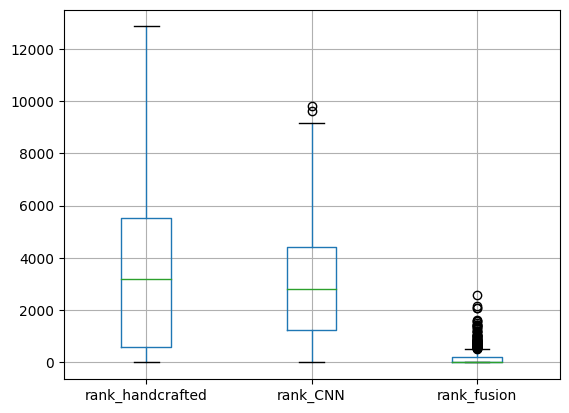

In [ ]:
import tqdm
for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "rank_handcrafted"] = evaluate_query(df, matrix, row["image_name"], normalized=False)

for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "rank_CNN"] = evaluate_query(df, matrix_cnn, row["image_name"], normalized=False)

for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "rank_fusion"] = evaluate_query(df, matrix_fusion, row["image_name"], normalized=False)

# drop non numeric columns
df_grouped = df.drop(["image_name", "similarity", "Nrank_handcrafted", "Nrank_CNN", "Nrank_fusion"], axis=1)
# group by class
df_grouped = df_grouped.groupby("class").mean()
# generate a box plot for each column
df_grouped.boxplot()
plt.show()

##### Estadística descriptiva sobre el Ranking para los métodos construidos

In [ ]:
df_grouped.describe()

rank_handcrafted     rank_CNN  rank_fusion
count       1700.000000  1700.000000  1700.000000
mean        3381.544337  2960.011163   145.996183
std         2794.454267  1965.402397   253.381632
min            1.000000     1.000000     1.000000
25%          578.444444  1255.861111     2.500000
50%         3190.727778  2813.494444    14.505556
75%         5526.461111  4429.769444   212.938889
max        12855.500000  9808.333333  2562.677778

##### Boxplot de Rank Normalizado para los métodos construidos

100%|██████████| 13491/13491 [01:15<00:00, 178.13it/s]


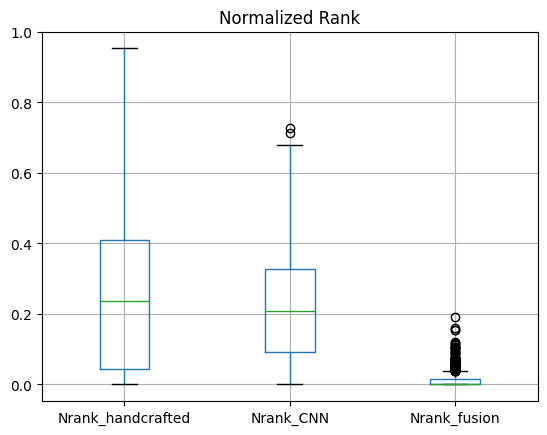

In [ ]:
import tqdm
for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "Nrank_handcrafted"] = evaluate_query(df, matrix, row["image_name"], normalized=True)

for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "Nrank_CNN"] = evaluate_query(df, matrix_cnn, row["image_name"], normalized=True)

for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "Nrank_fusion"] = evaluate_query(df, matrix_fusion, row["image_name"], normalized=True)

# drop non numeric columns
df_grouped = df.drop(["image_name", "rank_fusion", "rank_CNN", "rank_handcrafted", "similarity"], axis=1)
# group by class
df_grouped = df_grouped.groupby("class").mean()
# generate a box plot for each column
df_grouped.boxplot()
plt.title("Normalized Rank")
plt.show()


##### Estadística descriptiva sobre el Ranking Normalizado para los métodos construidos


In [ ]:
df_grouped.describe()

Nrank_handcrafted    Nrank_CNN  Nrank_fusion
count        1700.000000  1700.000000   1700.000000
mean            0.250358     0.219112      0.010528
std             0.207071     0.145630      0.018739
min             0.000000     0.000000      0.000000
25%             0.042617     0.092718      0.000000
50%             0.236284     0.208175      0.000719
75%             0.409270     0.327979      0.015413
max             0.952783     0.726657      0.189584

### Curvas Precision-Recall

Para evaluar los métodos implementados corresponde calcular las curvas precision recall para cada uno de estos. El proposito de las curvas Precision Recall es evaluar y visualizar el performance de los métodos en la tarea CBIR. Un método que arroje buenos resultados tiene una curva PR que se aleja del origen, como en la imagen de ejemplo.

La función `precision_recall()` calcula la curva precision recall para un método dado y una imagen de consulta, variando el número de imágenes recuperadas.

 


La **precisión** se calcula dividiendo el número de imágenes relevantes recuperadas correctamente (verdaderos positivos, TP) entre el número total de imágenes recuperadas (TP + FP):

$ \text{Precisión} = \frac{TP}{TP + FP} = \frac{TP}{\text{Total retrieved}}$

El **recall** se calcula dividiendo el número de imágenes relevantes recuperadas correctamente (TP) entre el número total de imágenes relevantes en el conjunto de datos (TP + FN):

$ \text{Recall} = \frac{TP}{TP + FN} = \frac{TP}{\text{Total relevant}}$


Donde TP representa el número de verdaderos positivos (imágenes relevantes recuperadas correctamente), FP representa el número de falsos positivos (imágenes no relevantes recuperadas incorrectamente) y FN representa el número de falsos negativos (imágenes relevantes no recuperadas).




In [ ]:
image_example = df["image_name"][0]
precision_recall(df, matrix_fusion, IMAGE_EXAMPLE, n_retrieved=100)

(0.08, 0.8888888888888888)

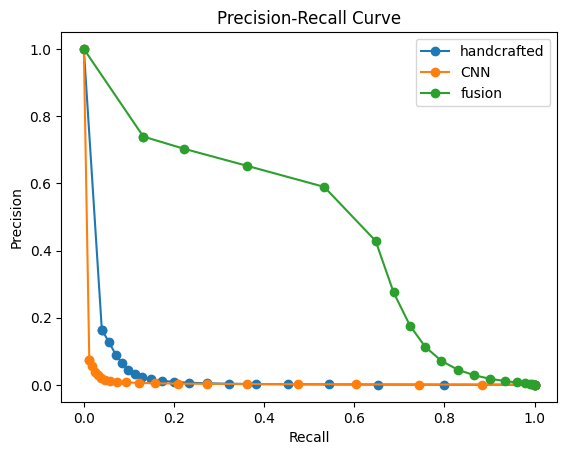

In [ ]:
import tqdm
import numpy as np
N = np.logspace(0, np.log10(len(df)), 20)
precision = {
    "handcrafted": [],
    "CNN": [],
    "fusion": []
}
recall = {
    "handcrafted": [],
    "CNN": [],
    "fusion": []
}
for N_ in tqdm.tqdm(N):
    precision_aux = 0
    recall_aux = 0
    for i in range(len(df)):
        row = df.iloc[i,:]
        precision_, recall_ = precision_recall(df, matrix, row["image_name"], n_retrieved=int(N_))
        precision_aux += precision_
        recall_aux += recall_
    precision["handcrafted"].append(precision_aux/len(df))
    recall["handcrafted"].append(recall_aux/len(df))

    precision_aux = 0
    recall_aux = 0
    for i in range(len(df)):
        row = df.iloc[i,:]
        precision_, recall_ = precision_recall(df, matrix_cnn, row["image_name"], n_retrieved=int(N_))
        precision_aux += precision_
        recall_aux += recall_
    precision["CNN"].append(precision_aux/len(df))
    recall["CNN"].append(recall_aux/len(df))

    precision_aux = 0
    recall_aux = 0
    for i in range(len(df)):
        row = df.iloc[i,:]
        precision_, recall_ = precision_recall(df, matrix_fusion, row["image_name"], n_retrieved=int(N_))
        precision_aux += precision_
        recall_aux += recall_
    precision["fusion"].append(precision_aux/len(df))
    recall["fusion"].append(recall_aux/len(df))


for key in precision.keys():
    recall[key].append(1)
    precision[key].append(0)
    recall[key].insert(0, 0)
    precision[key].insert(0, 1)


plt.plot(recall["handcrafted"], precision["handcrafted"], "o-", label="handcrafted")
plt.plot(recall["CNN"], precision["CNN"], "o-", label="CNN")
plt.plot(recall["fusion"], precision["fusion"], "o-", label="fusion")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


##### Análisis de la curva PR

Se puede observar en el gráfico que las curvas del método "handcrafted" y CNN funcionan mal por separado, pero al fusionarlas se obtiene una curva que funciona mejor, principalmente se atribuye a que la reducción de dimensionalidad por el método LDA permite que las clases se separen mejor, y por lo tanto, se obtienen mejores resultados en la recuperación de imágenes.

### Consultando la base de datos con todos los métodos

5200
Handcrafted query time:9.265
CNN query time:9.447
Fusion query time:9.285


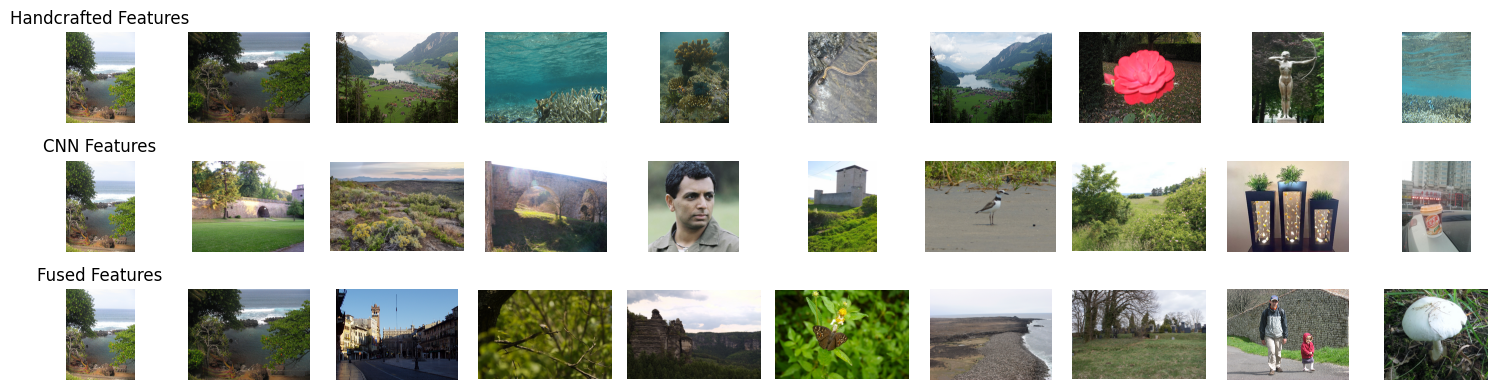

9411
Handcrafted query time:9.517
CNN query time:9.514
Fusion query time:9.852


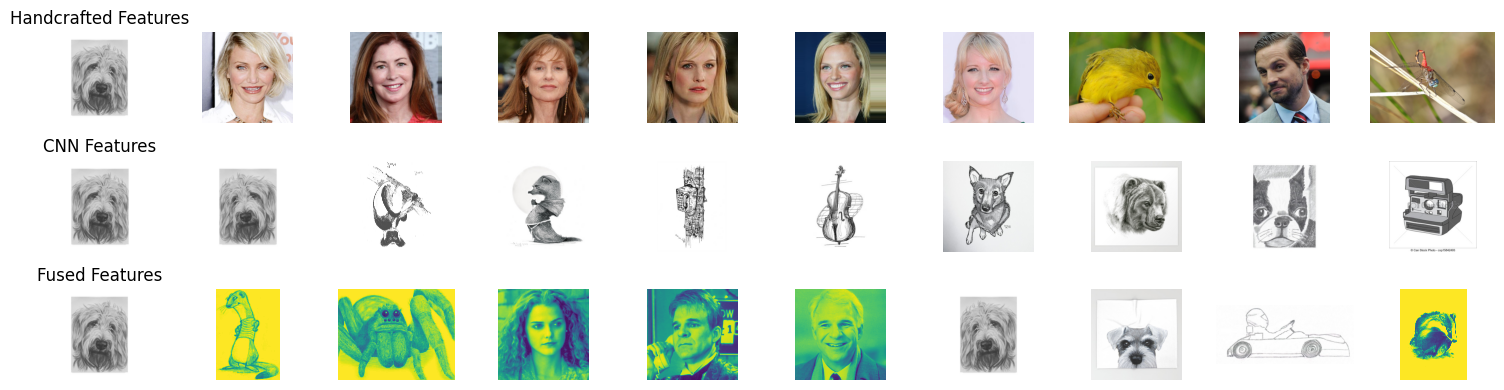

12414
Handcrafted query time:9.61
CNN query time:9.372
Fusion query time:9.189


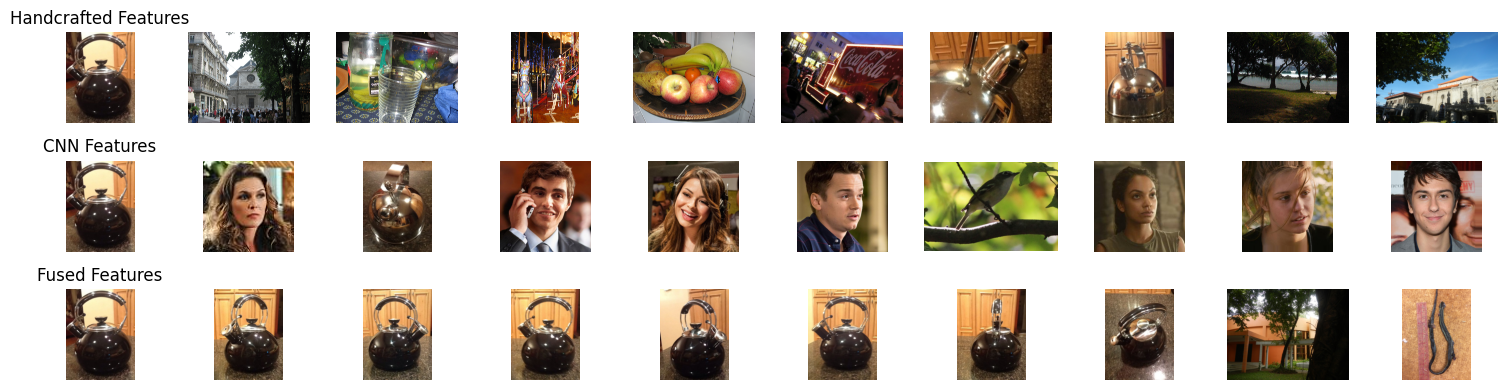

5732
Handcrafted query time:9.335
CNN query time:9.307
Fusion query time:9.215


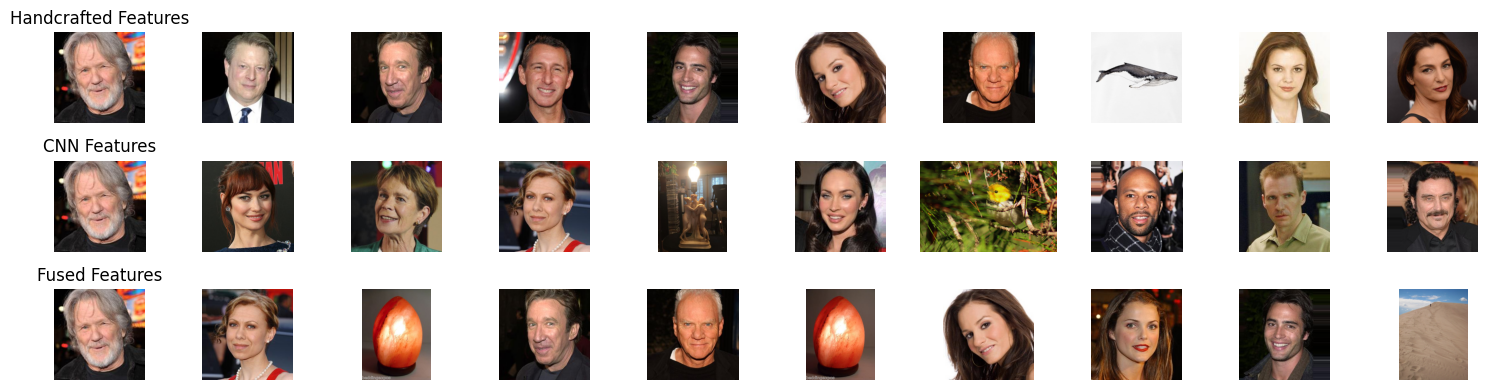

4059
Handcrafted query time:9.131
CNN query time:9.321
Fusion query time:9.125


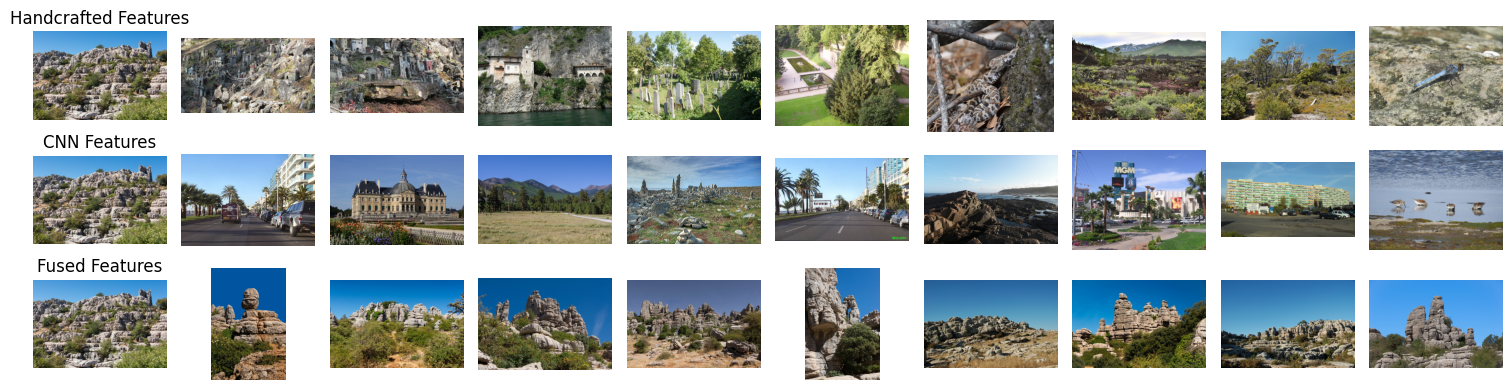

In [7]:
five_random = [np.random.randint(df.shape[0]) for i in range(5)]
#print(five_random)

for index in five_random:
    print(f"Consultando imagen número {index}")
    consult_all(df,df["image_name"][index],MEASURE,PATH_TO_IMAGES)

## Conclusiones

En base a los hallazgos y experimentos presentados, se pueden concluir los siguientes puntos:

1. El proyecto fue capaz de abordar con éxito la implementación de un algoritmo CBIR, utilizando varios métodos para la extracción de características. Los métodos explorados incluyen un enfoque "handcrafted" basado en Bag of Visual Words (BoVW), una técnica basada en Redes Neuronales Convolucionales (CNN), y una combinación de ambos.

2. Para el método "handcrafted", se observó que es menos sensible al color, ya que las imágenes se convierten a escala de grises antes de calcular los descriptores. A pesar de esta limitación, la metodología resultó útil para el objetivo del proyecto. Este método también resultó en una dimensión de vector más pequeña en comparación con los otros métodos, lo que podría ser beneficioso para el tiempo de consulta.

3. La técnica basada en CNN mostró una mayor sensibilidad a los patrones de color y textura en las imágenes y resultó en vectores característicos de mayor dimensión. La adopción de un modelo preentrenado facilitó la implementación de este enfoque y permitió concentrarse en la tarea de búsqueda de contenido por imágenes.

4. La combinación de los métodos "handcrafted" y CNN para formar un vector de características unificado logró mejorar el rendimiento de las consultas. La utilización de Análisis Discriminante Lineal (LDA) para reducir la dimensionalidad de estos vectores combinados resultó efectiva, y el vector final obtenido fue más corto que el vector de la CNN, pero más largo que el vector obtenido a través del método "handcrafted".

5. La evaluación de los tres métodos a través de las curvas Precision-Recall y la métrica de `rank` mostró que el método combinado superó a los otros dos métodos en términos de precisión y recall. Los métodos "handcrafted" y CNN tuvieron un desempeño subóptimo cuando se usaron por separado.
6. A pesar de las diferencias en la precisión y la recuperación entre los tres métodos, el tiempo de búsqueda fue similar en todos los casos. Esto sugiere que el costo computacional de la búsqueda es aproximadamente constante, independientemente de la dimensión del vector característico.

7. En general, los resultados apoyan la idea de que combinar diferentes métodos para la extracción de características puede conducir a mejoras significativas en la precisión y la recuperación en tareas de búsqueda de imágenes por contenido. Sin embargo, también resalta la importancia de la reducción de la dimensionalidad y la elección de una medida de similitud adecuada.